In [1]:
# RUNTIME = 'colab'
RUNTIME = 'local'

In [2]:
if RUNTIME == 'colab':
    %%capture
    !pip install polygon-api-client
    !pip install requests
    !pip install pandas
    !pip install tqdm
    !pip install mplfinance
    !pip install tensorflow
    !pip install numpy
    !pip install matplotlib
    !pip install scikit-learn
    !pip install fastparquet

In [132]:
import os
import calendar
from datetime import datetime, timedelta
from functools import partial

from polygon import RESTClient
import requests
import pandas as pd
from tqdm.notebook import tqdm
import mplfinance as mpf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Dropout,
                                     Activation,
                                     SimpleRNN,
                                     Flatten)
from tensorflow.keras.metrics import Precision, Recall, AUC

import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [4]:
if RUNTIME == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

# 1. Load Data

In [5]:
def get(path, params={}):
    session = requests.Session()
    url = 'https://api.polygon.io' + path
    params['apiKey'] = os.environ['POLYGON_API_KEY']
    resp = session.request('GET', url, params=params)
    resp.raise_for_status()
    return resp.json()

In [6]:
def get_bars(from_date, to_date):
    if isinstance(from_date, datetime):
        from_date = datetime.strftime(from_date, '%Y-%m-%d')
    if isinstance(to_date, datetime):
        to_date = datetime.strftime(to_date, '%Y-%m-%d')
    return get('/v2/aggs/ticker/{}/range/{}/{}/{}/{}'.format('SBUX',
                                                             1,
                                                             'minute',
                                                             from_date,
                                                             to_date))['results']

In [7]:
class TradingDay:
    def __init__(self, date):
        if isinstance(date, str):
            self.start = datetime.strptime(date, '%Y-%m-%d')
        if isinstance(date, datetime):
            self.start = date
        self.end = self.start + timedelta(days=1)
        #self.weekday = calendar.day_name[self.start.weekday()]
        self.bars = pd.DataFrame(columns=['timestamp',
                                          'volume',
                                          'open',
                                          'close',
                                          'high',
                                          'low',
                                          'num_trades'])
        for bar in get_bars(self.start, self.end):
            self.bars = self.bars.append({
                'timestamp': bar['t'],
                'volume': bar['v'],
                'open': bar['o'],
                'close': bar['c'],
                'high': bar['h'],
                'low': bar['l'],
                'num_trades': bar.get('n', 0)
            }, ignore_index=True)
        
class TradingYear:
    def __init__(self, year):
        self.days = [
            TradingDay(
                datetime.strptime(
                    '{}-2019'.format(str(day)), '%j-%Y'
                )
            ) for day in tqdm(range(1,366))
        ]
   
    def get_bars(self):
        return pd.concat([day.bars for day in self.days])

If there is a data file, load it. If not, request data from the Polygon API and save it to a file.

In [8]:
if RUNTIME == 'local':
    DIR = '.data/2019_year_df.parquet.gzip'
elif RUNTIME == 'colab':
    DIR = '/content/drive/My Drive/pbc/2019_year_df.parquet.gzip'

try:
    year_df = pd.read_parquet(DIR)
except FileNotFoundError as e:
    year_df = TradingYear(2019).get_bars()
    year_df['timestamp'] = pd.to_datetime(year_df['timestamp'], unit='ms')
    year_df = year_df.set_index('timestamp')
    year_df.to_parquet(DIR, compression='gzip')

<AxesSubplot:xlabel='timestamp'>

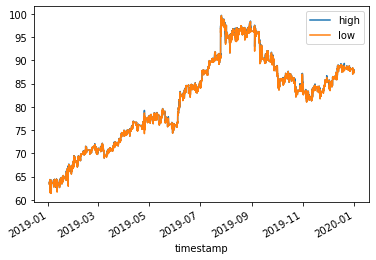

In [9]:
year_df[['high', 'low']].plot()

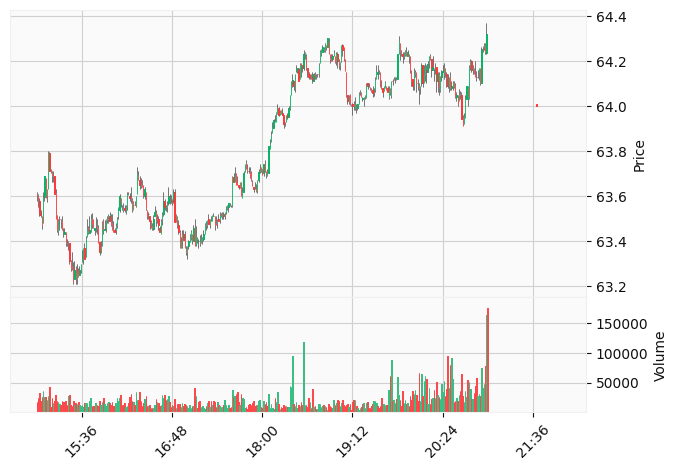

In [10]:
mpf.plot(year_df.loc['2019-01-02 15:00':'2019-01-02 22:00',:], type='candle', volume=True, show_nontrading=True, style='yahoo')


# 2. Feature Engineering

In [11]:
year_df.head()

,volume,open,close,high,low,num_trades
timestamp,,,,,,
2019-01-02 12:17:00,300.0,63.67,63.68,63.68,63.67,4.0
2019-01-02 12:21:00,487.0,63.50,63.53,63.53,63.50,5.0
2019-01-02 12:22:00,1949.0,63.50,63.50,63.50,63.47,8.0
2019-01-02 12:31:00,203.0,63.52,63.52,63.52,63.52,3.0
2019-01-02 12:34:00,238.0,63.55,63.55,63.55,63.55,4.0


Compute the labels we're training for:

In [12]:
WINDOW_SIZE = 5  # looking 5 bars into the future

PCT_WINDOWS = [0.05, 0.1, 0.15, 0.2, 0.25]
LABELS = (['down_{}_pct'.format(pct) for pct in sorted(PCT_WINDOWS, reverse=True)] +
          ['up_{}_pct'.format(pct) for pct in sorted(PCT_WINDOWS)])

In [14]:
tqdm.pandas()  # graphical load bar

def compute_label(formatted_df, pct, direction, row):
    window = formatted_df[formatted_df.index > row.name].iloc[:WINDOW_SIZE]
    if len(window) == WINDOW_SIZE:
        if direction == 'up':
            return int(max(window['high']) >= row['close']*(1+(pct/100)))
        return int(min(window['low']) <= row['close']*(1-(pct/100)))
    return None

/Users/john/.local/share/virtualenvs/pbc-AS_-2Y6Z/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [15]:
if RUNTIME == 'local':
    FORMATTED_DF_DIR = '.data/formatted_df.parquet.gzip'
elif RUNTIME == 'colab':
    FORMATTED_DF_DIR = '/content/drive/My Drive/pbc/formatted_df.parquet.gzip'

try:
    formatted_df = pd.read_parquet(FORMATTED_DF_DIR)
except FileNotFoundError as e:
    # sanitize
    formatted_df = (year_df
        .sort_index(inplace=False)
        .drop_duplicates()
        # filter out times before 9:30 and after 4:00
        .between_time('13:30','20:00')
        .dropna()
    )
    
    # compute labels
    for pct in [0.05, 0.1, 0.15, 0.2, 0.25]:
        formatted_df['up_{}_pct'.format(pct)] = formatted_df.progress_apply(partial(compute_label, formatted_df, pct, 'up'), axis=1)
        formatted_df['down_{}_pct'.format(pct)] = formatted_df.progress_apply(partial(compute_label, formatted_df, pct, 'down'), axis=1)
    
    # compute features
    formatted_df['open_close_pct_delta'] = (formatted_df['close'] - formatted_df['open'])/formatted_df['open']
    formatted_df['vol'] = (formatted_df['high'] - formatted_df['low'])/formatted_df['open']
    formatted_df['{}min_vol_std'.format(WINDOW_SIZE)] = formatted_df['vol'].rolling(5).std()
    formatted_df['{}min_ocd_std'.format(WINDOW_SIZE)] = formatted_df['open_close_pct_delta'].rolling(5).std()
    scaler = MinMaxScaler()
    formatted_df[['scaled_volume']] = scaler.fit_transform(formatted_df[['volume']])
    
    
    formatted_df = formatted_df.dropna()
    formatted_df.to_parquet(FORMATTED_DF_DIR, compression='gzip')


In [16]:
#mpf.plot(formatted_df, type='candle', volume=True, show_nontrading=True, style='yahoo')

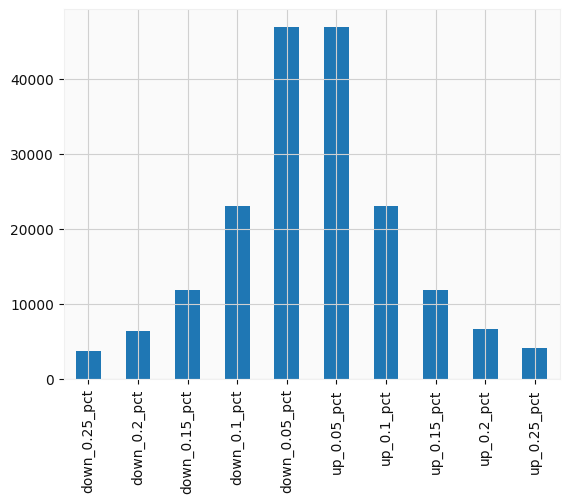

In [17]:
def plot_label_frequency():
    formatted_df[LABELS].sum().plot(kind='bar')
plot_label_frequency()

# 3. Attempt #1: Simple Neural Net

In [37]:
FEATURES = ['open_close_pct_delta', 'vol', '5min_vol_std', '5min_ocd_std', 'scaled_volume']

X_all = formatted_df[FEATURES]
twenty_pct = (len(X_all)//5)
X_train, X_val, X_test = X_all[:twenty_pct*3], X_all[twenty_pct*3:twenty_pct*4], X_all[twenty_pct*4:]
y_all = formatted_df[LABELS]
y_train, y_val, y_test = y_all[:twenty_pct*3], y_all[twenty_pct*3:twenty_pct*4], y_all[twenty_pct*4:]

display(X_all.describe())

,open_close_pct_delta,vol,5min_vol_std,5min_ocd_std,scaled_volume
count,93683.000000,93683.000000,93683.000000,93683.000000,93683.000000
mean,-0.000006,0.000589,0.000258,0.000410,0.006672
std,0.000527,0.000551,0.000291,0.000336,0.012736
min,-0.013842,0.000000,0.000000,0.000000,0.000000
25%,-0.000235,0.000289,0.000128,0.000218,0.002808
50%,0.000000,0.000456,0.000190,0.000325,0.004432
75%,0.000223,0.000710,0.000291,0.000492,0.007208
max,0.009662,0.021831,0.008706,0.008565,1.000000


In [62]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
#model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(multi_label=True)])

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=20)

Epoch 1/50
2811/2811 [==============================] - 5s 2ms/step - loss: 0.4006 - accuracy: 0.3100 - precision_3: 0.5350 - recall_3: 0.2312 - auc_1: 0.6158 - val_loss: 0.4226 - val_accuracy: 0.2614 - val_precision_3: 0.6607 - val_recall_3: 0.1591 - val_auc_1: 0.7057
Epoch 2/50
2811/2811 [==============================] - 4s 2ms/step - loss: 0.3811 - accuracy: 0.3098 - precision_3: 0.5863 - recall_3: 0.2588 - auc_1: 0.6925 - val_loss: 0.4335 - val_accuracy: 0.2557 - val_precision_3: 0.6937 - val_recall_3: 0.1319 - val_auc_1: 0.7210
Epoch 3/50
2811/2811 [==============================] - 4s 2ms/step - loss: 0.3755 - accuracy: 0.3125 - precision_3: 0.5947 - recall_3: 0.2788 - auc_1: 0.7108 - val_loss: 0.4191 - val_accuracy: 0.2745 - val_precision_3: 0.6831 - val_recall_3: 0.1908 - val_auc_1: 0.7315
Epoch 4/50
2811/2811 [==============================] - 4s 1ms/step - loss: 0.3724 - accuracy: 0.3117 - precision_3: 0.5998 - recall_3: 0.2935 - auc_1: 0.7189 - val_loss: 0.3997 - val_accura

2811/2811 [==============================] - 4s 1ms/step - loss: 0.3704 - accuracy: 0.3090 - precision_3: 0.6021 - recall_3: 0.3160 - auc_1: 0.7258 - val_loss: 0.4008 - val_accuracy: 0.3406 - val_precision_3: 0.6189 - val_recall_3: 0.3458 - val_auc_1: 0.7340
Epoch 32/50
2811/2811 [==============================] - 4s 1ms/step - loss: 0.3704 - accuracy: 0.3168 - precision_3: 0.6021 - recall_3: 0.3134 - auc_1: 0.7260 - val_loss: 0.4002 - val_accuracy: 0.2580 - val_precision_3: 0.6292 - val_recall_3: 0.3262 - val_auc_1: 0.7335
Epoch 33/50
2811/2811 [==============================] - 4s 1ms/step - loss: 0.3702 - accuracy: 0.3120 - precision_3: 0.6023 - recall_3: 0.3146 - auc_1: 0.7264 - val_loss: 0.4052 - val_accuracy: 0.3406 - val_precision_3: 0.6389 - val_recall_3: 0.2962 - val_auc_1: 0.7330
Epoch 34/50
2811/2811 [==============================] - 4s 1ms/step - loss: 0.3702 - accuracy: 0.3112 - precision_3: 0.6028 - recall_3: 0.3124 - auc_1: 0.7258 - val_loss: 0.4010 - val_accuracy: 0.34

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 5,194
Trainable params: 5,194
Non-trainable params: 0
_________________________________________________________________


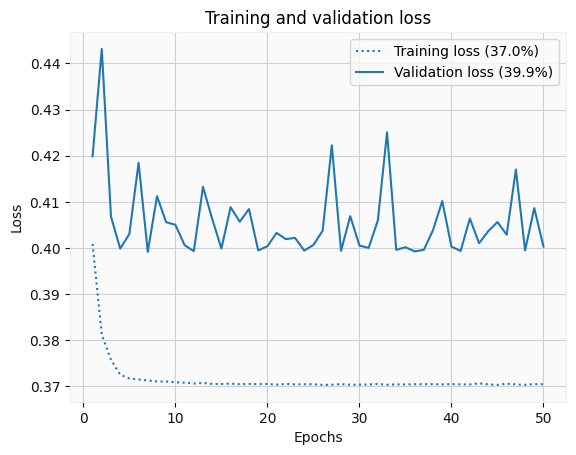

In [58]:
import matplotlib.pyplot as plt

def plot_loss(history):
    fig, axis = plt.subplots()
    color = next(axis._get_lines.prop_cycler)['color']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    axis.plot(epochs,
              loss,
              color=color,
              linestyle='dotted',
              label='Training loss ({:.3}%)'.format(min(loss)*100))
    axis.plot(epochs,
              val_loss,
              color=color,
              label='Validation loss ({:.3}%)'.format(min(val_loss)*100))
    axis.set_title('Training and validation loss')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('Loss')
    axis.legend()

    plt.show()
    
plot_loss(history)

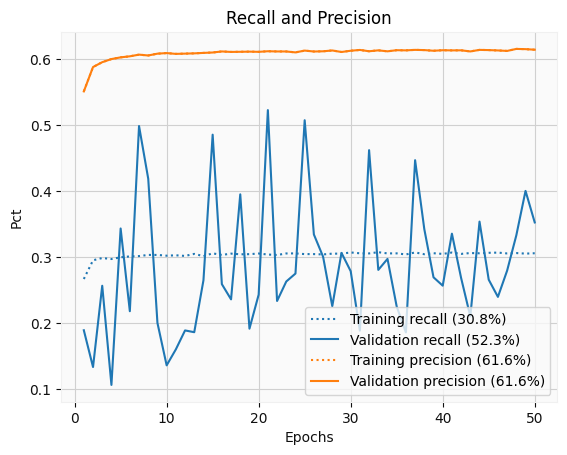

In [144]:
def plot_recall_precision(history):
    fig, axis = plt.subplots()
    
    color = next(axis._get_lines.prop_cycler)['color']
    recall = history.history.get('recall') or history.history.get('recall_13')
    val_recall = history.history.get('val_recall')  or history.history.get('val_recall_13')
    
    epochs = range(1, len(recall) + 1)
    
    axis.plot(epochs,
             recall,
             color=color,
             linestyle='dotted',
             label='Training recall ({:.3}%)'.format(max(recall)*100))
    axis.plot(epochs,
             val_recall,
             color=color,
             label='Validation recall ({:.3}%)'.format(max(val_recall)*100))
    
    color = next(axis._get_lines.prop_cycler)['color']
    precision = history.history.get('precision')  or history.history.get('precision_13')
    val_precision = history.history.get('val_precision')  or history.history.get('precision_13')
    
    axis.plot(epochs,
             precision,
             color=color,
             linestyle='dotted',
             label='Training precision ({:.3}%)'.format(max(precision)*100))
    axis.plot(epochs,
             val_precision,
             color=color,
             label='Validation precision ({:.3}%)'.format(max(val_precision)*100))
    
    axis.set_title('Recall and Precision')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('Pct')
    axis.legend()

    plt.show()
    
plot_recall_precision(history)

# 4. Attempt #2: SimpleRNN

In [115]:
display(X_test.head())

trailing_values = []
trailing_col = []
for idx, row in X_all.iterrows():
    trailing_values.append(np.asarray(row.values))
    if len(trailing_values) >= WINDOW_SIZE:
        trailing_col.append(np.asarray(trailing_values))
        trailing_values.pop(0)
    else:
        trailing_col.append(None)
#display(trailing_col[4:8])
#assert trailing_col[5] != trailing_col[6]

RNN_df = pd.DataFrame({
    **y_all,
    **{'trailing_col': trailing_col}
}, index=X_all.index)
RNN_df = RNN_df.dropna()

X_all_RNN = RNN_df[['trailing_col']]
y_all_RNN = RNN_df[y_all.columns]
display(X_all_RNN.head())
display(y_all_RNN)

,open_close_pct_delta,vol,5min_vol_std,5min_ocd_std,scaled_volume
timestamp,,,,,
2019-10-15 14:37:00,0.000231,0.000461,0.000139,0.000243,0.003060
2019-10-15 14:38:00,-0.000696,0.000938,0.000198,0.000412,0.002121
2019-10-15 14:39:00,-0.000197,0.000922,0.000234,0.000331,0.005704
2019-10-15 14:40:00,0.000866,0.000924,0.000209,0.000587,0.005392
2019-10-15 14:41:00,-0.000231,0.000923,0.000208,0.000587,0.013734


,trailing_col
timestamp,
2019-01-02 14:32:00,"[[0.0, 0.0, 0.0006213721524858403, 0.000656455..."
2019-01-02 14:33:00,"[[0.0, 0.0, 0.0006213721524858403, 0.000656455..."
2019-01-02 14:34:00,"[[-0.0010992462311557834, 0.00329773869346735,..."
2019-01-02 14:35:00,"[[0.005345911949685476, 0.005660377358490557, ..."
2019-01-02 14:36:00,"[[-0.0007822277847309803, 0.002346683354192718..."


,down_0.25_pct,down_0.2_pct,down_0.15_pct,down_0.1_pct,down_0.05_pct,up_0.05_pct,up_0.1_pct,up_0.15_pct,up_0.2_pct,up_0.25_pct
timestamp,,,,,,,,,,
2019-01-02 14:32:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2019-01-02 14:33:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2019-01-02 14:34:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2019-01-02 14:35:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2019-01-02 14:36:00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:51:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 19:52:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 19:53:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [116]:

twenty_pct = (len(X_all_RNN)//5)
X_RNN_train, X_RNN_val, X_RNN_test = X_all_RNN[:twenty_pct*3], X_all_RNN[twenty_pct*3:twenty_pct*4], X_all_RNN[twenty_pct*4:]
y_RNN_train, y_RNN_val, y_RNN_test = y_all_RNN[:twenty_pct*3], y_all_RNN[twenty_pct*3:twenty_pct*4], y_all_RNN[twenty_pct*4:]


In [129]:
np.stack(X_RNN_train['trailing_col'].values)

array([[[ 0.00000000e+00,  0.00000000e+00,  6.21372152e-04,
          6.56455525e-04,  6.76616737e-05],
        [ 0.00000000e+00,  0.00000000e+00,  6.21372152e-04,
          6.56455525e-04,  1.52850166e-04],
        [-1.09924623e-03,  3.29773869e-03,  1.45262711e-03,
          8.95181327e-04,  5.92121165e-02],
        [ 5.34591195e-03,  5.66037736e-03,  2.59159139e-03,
          2.55833358e-03,  8.84452203e-03],
        [-7.82227785e-04,  2.34668335e-03,  2.39072045e-03,
          2.64568191e-03,  1.17556044e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  6.21372152e-04,
          6.56455525e-04,  1.52850166e-04],
        [-1.09924623e-03,  3.29773869e-03,  1.45262711e-03,
          8.95181327e-04,  5.92121165e-02],
        [ 5.34591195e-03,  5.66037736e-03,  2.59159139e-03,
          2.55833358e-03,  8.84452203e-03],
        [-7.82227785e-04,  2.34668335e-03,  2.39072045e-03,
          2.64568191e-03,  1.17556044e-02],
        [ 1.56617071e-04,  2.03602193e-03,  2.05983965e-03,
  

In [138]:
model_name = "simple_rnn"
n_timesteps = WINDOW_SIZE
n_features = len(X_all_RNN['trailing_col'].iloc[0])

display((n_timesteps, n_features))

model = Sequential()
model.add(SimpleRNN(64,
                    activation='linear',
                    input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation='linear'))
model.add(Dense(y_RNN_train.shape[1], activation='sigmoid'))

model.summary()

(5, 5)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 64)                4480      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 10)                650       
Total params: 9,290
Trainable params: 9,290
Non-trainable params: 0
_________________________________________________________________


In [139]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(multi_label=True)])

history = model.fit(np.stack(X_RNN_train['trailing_col'].values),
                    y_RNN_train,
                    validation_data=(np.stack(X_RNN_val['trailing_col'].values),
                                     y_RNN_val),
                    epochs=50,
                    batch_size=20)

Epoch 1/50
2811/2811 [==============================] - 7s 2ms/step - loss: 0.3924 - accuracy: 0.3038 - precision_13: 0.5516 - recall_13: 0.2674 - auc_11: 0.6549 - val_loss: 0.4109 - val_accuracy: 0.2589 - val_precision_13: 0.6759 - val_recall_13: 0.1897 - val_auc_11: 0.7461
Epoch 2/50
2811/2811 [==============================] - 6s 2ms/step - loss: 0.3800 - accuracy: 0.3111 - precision_13: 0.5884 - recall_13: 0.2957 - auc_11: 0.7100 - val_loss: 0.4254 - val_accuracy: 0.3403 - val_precision_13: 0.7182 - val_recall_13: 0.1340 - val_auc_11: 0.7488
Epoch 3/50
2811/2811 [==============================] - 7s 2ms/step - loss: 0.3771 - accuracy: 0.3103 - precision_13: 0.5958 - recall_13: 0.2991 - auc_11: 0.7213 - val_loss: 0.4090 - val_accuracy: 0.2950 - val_precision_13: 0.6707 - val_recall_13: 0.2571 - val_auc_11: 0.7513
Epoch 4/50
2811/2811 [==============================] - 7s 2ms/step - loss: 0.3756 - accuracy: 0.3120 - precision_13: 0.6005 - recall_13: 0.2976 - auc_11: 0.7259 - val_loss

Epoch 31/50
2811/2811 [==============================] - 6s 2ms/step - loss: 0.3719 - accuracy: 0.3140 - precision_13: 0.6144 - recall_13: 0.3063 - auc_11: 0.7394 - val_loss: 0.4188 - val_accuracy: 0.3363 - val_precision_13: 0.6907 - val_recall_13: 0.1891 - val_auc_11: 0.7527
Epoch 32/50
2811/2811 [==============================] - 6s 2ms/step - loss: 0.3718 - accuracy: 0.3126 - precision_13: 0.6124 - recall_13: 0.3061 - auc_11: 0.7400 - val_loss: 0.4008 - val_accuracy: 0.2692 - val_precision_13: 0.5940 - val_recall_13: 0.4626 - val_auc_11: 0.7558
Epoch 33/50
2811/2811 [==============================] - 6s 2ms/step - loss: 0.3719 - accuracy: 0.3115 - precision_13: 0.6137 - recall_13: 0.3080 - auc_11: 0.7406 - val_loss: 0.4059 - val_accuracy: 0.2803 - val_precision_13: 0.6649 - val_recall_13: 0.2812 - val_auc_11: 0.7540
Epoch 34/50
2811/2811 [==============================] - 6s 2ms/step - loss: 0.3719 - accuracy: 0.3134 - precision_13: 0.6123 - recall_13: 0.3061 - auc_11: 0.7401 - val_

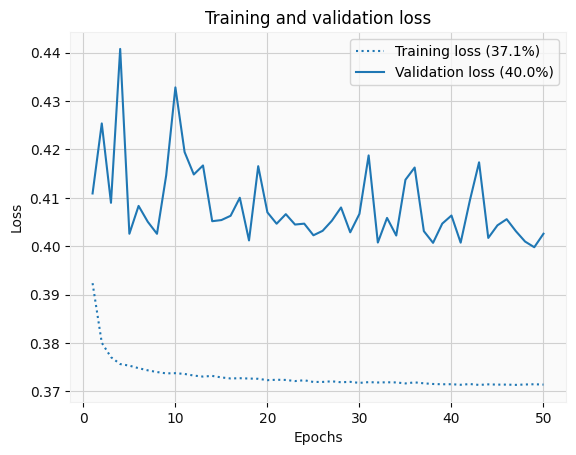

In [140]:
plot_loss(history)

In [142]:
history.history

{'loss': [0.3923635184764862,
  0.38004857301712036,
  0.37707439064979553,
  0.37564724683761597,
  0.37531572580337524,
  0.37479421496391296,
  0.37435096502304077,
  0.37399613857269287,
  0.3737197518348694,
  0.3737611174583435,
  0.3736046850681305,
  0.37326356768608093,
  0.3730608820915222,
  0.373198002576828,
  0.372883141040802,
  0.37266820669174194,
  0.3727225065231323,
  0.3726525604724884,
  0.37260305881500244,
  0.37231725454330444,
  0.37240245938301086,
  0.37236693501472473,
  0.37213078141212463,
  0.372299462556839,
  0.3719468414783478,
  0.37195542454719543,
  0.3720822036266327,
  0.37188461422920227,
  0.3719707429409027,
  0.3717520833015442,
  0.3719114065170288,
  0.37183877825737,
  0.37188106775283813,
  0.37185120582580566,
  0.3716457486152649,
  0.3718641996383667,
  0.3716675341129303,
  0.37152931094169617,
  0.37146827578544617,
  0.3714808225631714,
  0.37136584520339966,
  0.37151744961738586,
  0.3713352680206299,
  0.37145236134529114,
  0.37

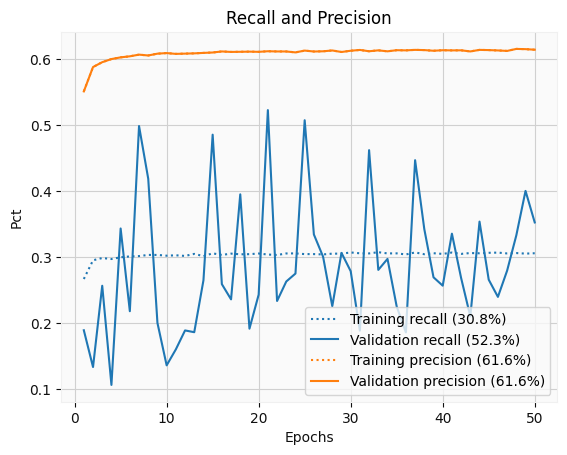

In [145]:
plot_recall_precision(history)

# 5. Analysis

In [39]:
def weight_from_label(label):
    direction, weight, _ = label.split("_")
    if direction == "up":
        return float(weight)
    return float(weight) * -1

def backtest(model):
    test_df = X_test.copy()
    balances = []
    indexes = []
    buy_price = None
    balance = 1000
    for idx, row in test_df.iterrows():
        balances.append(balance)
        indexes.append(idx)
        predictions = model.predict(np.reshape(row.to_numpy(),
                                               (-1, len(FEATURES))))[0]
        weighted_prediction = [weight_from_label(LABELS[idx])*pred
                               for idx, pred in enumerate(predictions)]
        if sum(weighted_prediction) < 0 and buy_price is not None:
            balance += (formatted_df.loc[idx]['close'] - buy_price)
            buy_price = None
        elif sum(weighted_prediction) > 0 and buy_price is None:
            buy_price = formatted_df.loc[idx]['close']
    return pd.Series(balances, index=indexes)

backtest(model).plot()


KeyboardInterrupt: 

<AxesSubplot:xlabel='timestamp'>

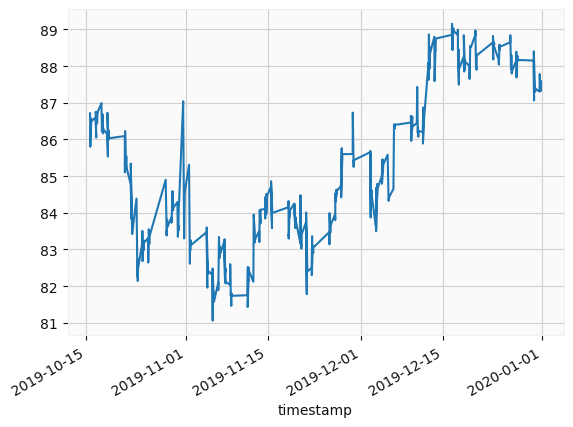

In [46]:
formatted_df['close'].loc[X_test.index[0]:].plot()


Timestamp('2019-10-15 14:37:00')